# Physique des marchés
## TP1 : Faits stylisés

Par : Adonis JAMAL

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow
import yfinance as yf
from scipy import stats
from scipy.signal import find_peaks
from statsmodels.distributions.empirical_distribution import ECDF
import powerlaw
from tqdm import tqdm

---
### 1. Buts du TP

- Manipuler des données financières et caractériser des faits stylisés.
- Utiliser des objets de séries temporelles.
- Fusionner des séries temporelles asynchrones.


---
### 2. Obtenir des données

#### 2.1 Données journalières

In [2]:
use_yfinance = True

if use_yfinance:
    tickers_list = ["^GSPC", "AMD", "MSFT", "INTC", "C", "IBM", "GE", "BTC-USD", "ETH-USD"]
    df = yf.download(tickers_list, start="1900-01-01", progress=True, auto_adjust=False)
    daily_df = df["Adj Close"]
    print(f"Data shape: {daily_df.shape}")
    print(daily_df.head())
else:
    daily_df = pd.read_parquet("../data/sp500_20161229.parquet", engine="pyarrow")
    daily_df["index"] = pd.to_datetime(daily_df["index"])
    daily_df.set_index("index", inplace=True)
    print(f"Data shape: {daily_df.shape}")
    print(daily_df.head())

[*********************100%***********************]  9 of 9 completed

Data shape: (25948, 9)
Ticker      AMD  BTC-USD   C  ETH-USD  GE  IBM  INTC  MSFT      ^GSPC
Date                                                                 
1927-12-30  NaN      NaN NaN      NaN NaN  NaN   NaN   NaN  17.660000
1928-01-03  NaN      NaN NaN      NaN NaN  NaN   NaN   NaN  17.760000
1928-01-04  NaN      NaN NaN      NaN NaN  NaN   NaN   NaN  17.719999
1928-01-05  NaN      NaN NaN      NaN NaN  NaN   NaN   NaN  17.549999
1928-01-06  NaN      NaN NaN      NaN NaN  NaN   NaN   NaN  17.660000


In [3]:
# Check data quality
print('null count:\n', daily_df.isnull().sum())
print('\nna count:\n', daily_df.isna().sum())

null count:
 Ticker
AMD        14375
BTC-USD    21777
C          13566
ETH-USD    22926
GE          9810
IBM         9810
INTC       14375
MSFT       15889
^GSPC       1301
dtype: int64

na count:
 Ticker
AMD        14375
BTC-USD    21777
C          13566
ETH-USD    22926
GE          9810
IBM         9810
INTC       14375
MSFT       15889
^GSPC       1301
dtype: int64


#### 2.2 Données intraday

In [4]:
def load_TRTH_bbo(filename,
             tz_exchange="America/New_York",
             open_time="09:30:00",
             close_time="16:00:00",
             only_regular_trading_hours=True):
    
    DF = pd.read_csv(filename)

    DF.index = pd.to_datetime(DF["xltime"], unit="D", origin="1899-12-30", utc=True)
    DF.index = DF.index.tz_convert(tz_exchange)  # .P stands for Arca, which is based at New York
    # DF.drop(columns="xltime", inplace=True)
    
    if only_regular_trading_hours:
        DF=DF.between_time(open_time, close_time)    # warning: ever heard e.g. about Thanksgivings?
        
    return DF

In [5]:
files = np.array([load_TRTH_bbo(f"../data/2017-01-{i}-AAPL.OQ-bbo.csv.gz") for i in ['03', '04', '05', '06', '09', '10', '11']], dtype=object)
intraday_df = pd.concat([df.assign(day=i) for i, df in enumerate(files)], ignore_index=True)
intraday_df.head()

,xltime,bid-price,bid-volume,ask-price,ask-volume,day
0,42738.604168,115.81,5,115.82,415,0
1,42738.604168,115.80,4,115.82,415,0
2,42738.604168,115.80,18,115.82,415,0
3,42738.604168,115.80,18,115.82,475,0
4,42738.604168,115.80,18,115.82,474,0


In [6]:
# Check data quality
print('null count:\n', intraday_df.isnull().sum())
print('\nna count:\n', intraday_df.isna().sum())

null count:
 xltime        0
bid-price     0
bid-volume    0
ask-price     0
ask-volume    0
day           0
dtype: int64

na count:
 xltime        0
bid-price     0
bid-volume    0
ask-price     0
ask-volume    0
day           0
dtype: int64


---
### 3. Calcul des rendements

#### 3.1 Données journalières

In [7]:
# Calculate log returns from Adjusted Close
daily_log_returns = np.log(daily_df).diff()
daily_log_returns.head()

Ticker,AMD,BTC-USD,C,ETH-USD,GE,IBM,INTC,MSFT,^GSPC
Date,,,,,,,,,
1927-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005647
1928-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002255
1928-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009640
1928-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006248


#### 3.2 Données intraday

In [8]:
# Market hours filtering already done in load_TRTH_bbo
# Datetime index
intraday_df.index = pd.to_datetime(intraday_df["xltime"], unit="D", origin="1899-12-30", utc=True)
intraday_df.index = intraday_df.index.tz_convert("America/New_York")

# Mid-price
intraday_df['mid_price'] = (intraday_df['bid-price'] + intraday_df['ask-price']) / 2

# Log returns
intraday_log_returns = intraday_df.groupby('day').apply(lambda x: np.log(x['mid_price'].resample('5s').last().ffill()).diff().dropna())
intraday_log_returns.head()

day  xltime                   
0    2017-01-03 09:30:05-05:00   -0.000346
     2017-01-03 09:30:10-05:00   -0.000043
     2017-01-03 09:30:15-05:00   -0.000735
     2017-01-03 09:30:20-05:00   -0.000432
     2017-01-03 09:30:25-05:00    0.000216
Name: mid_price, dtype: float64

---
### 4. Analyse empirique

#### 4.1 Rendements : types de distribution

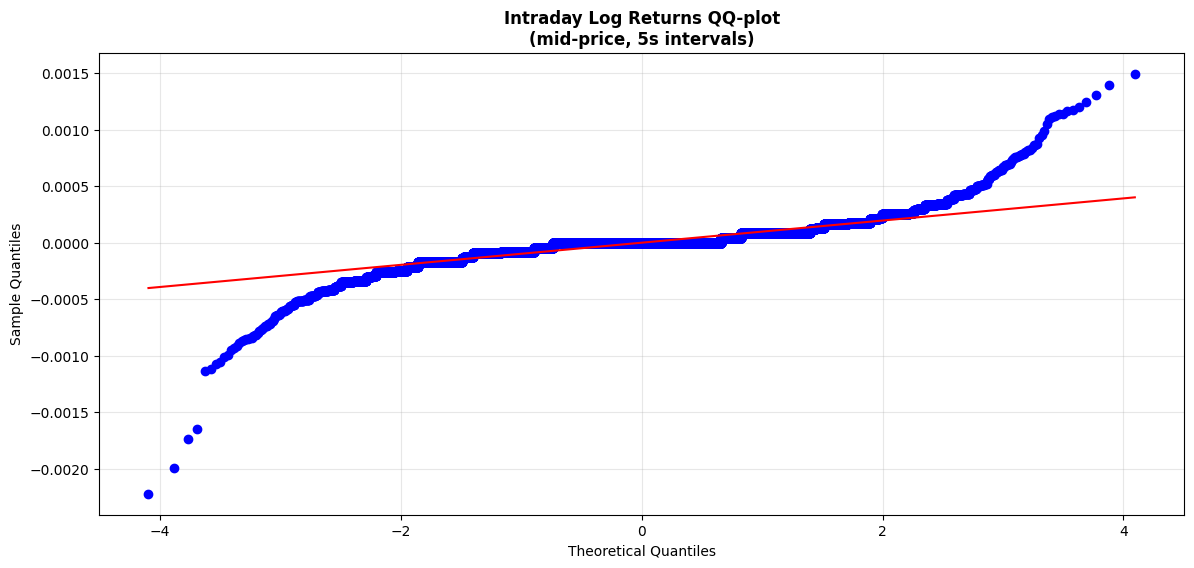

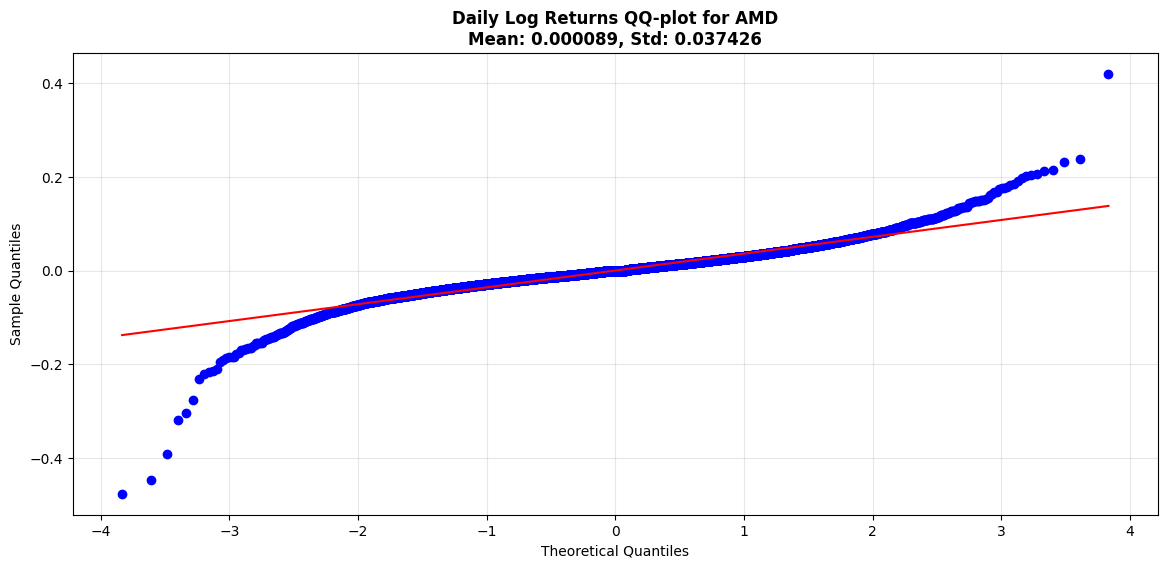

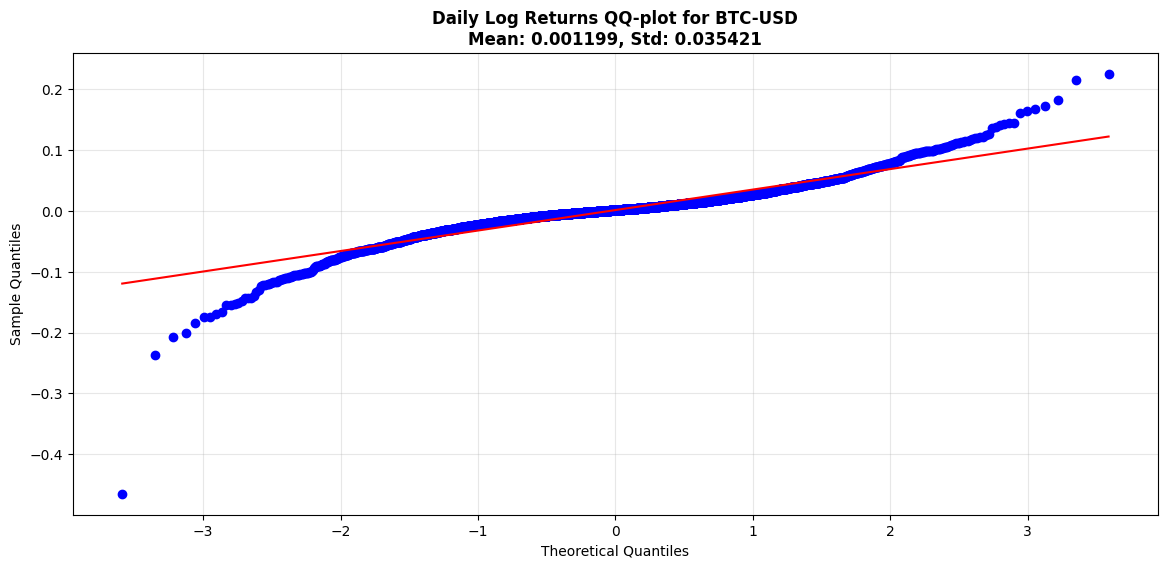

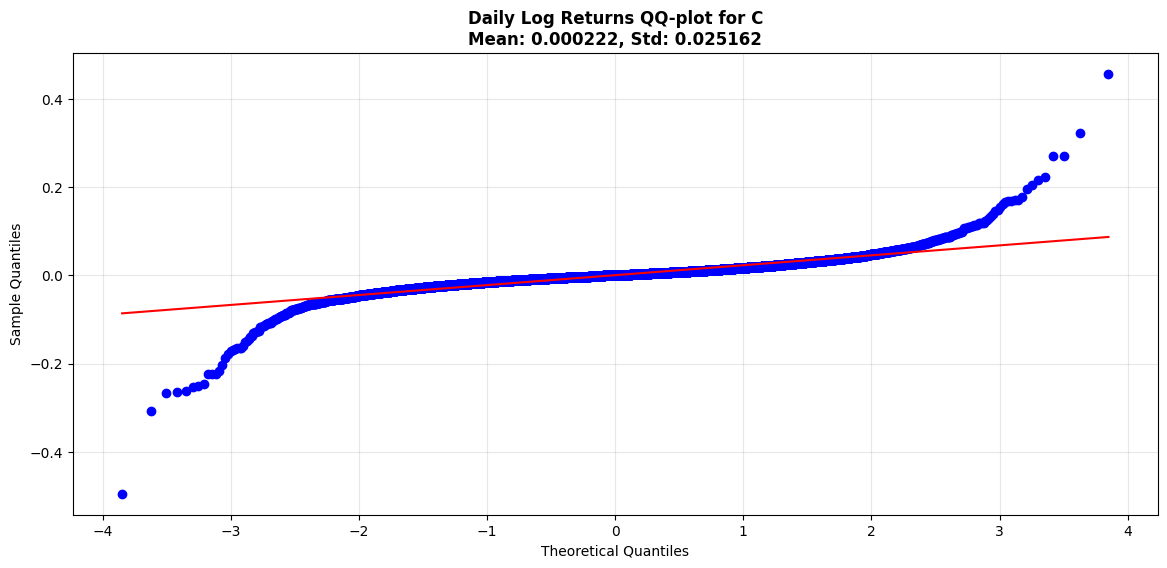

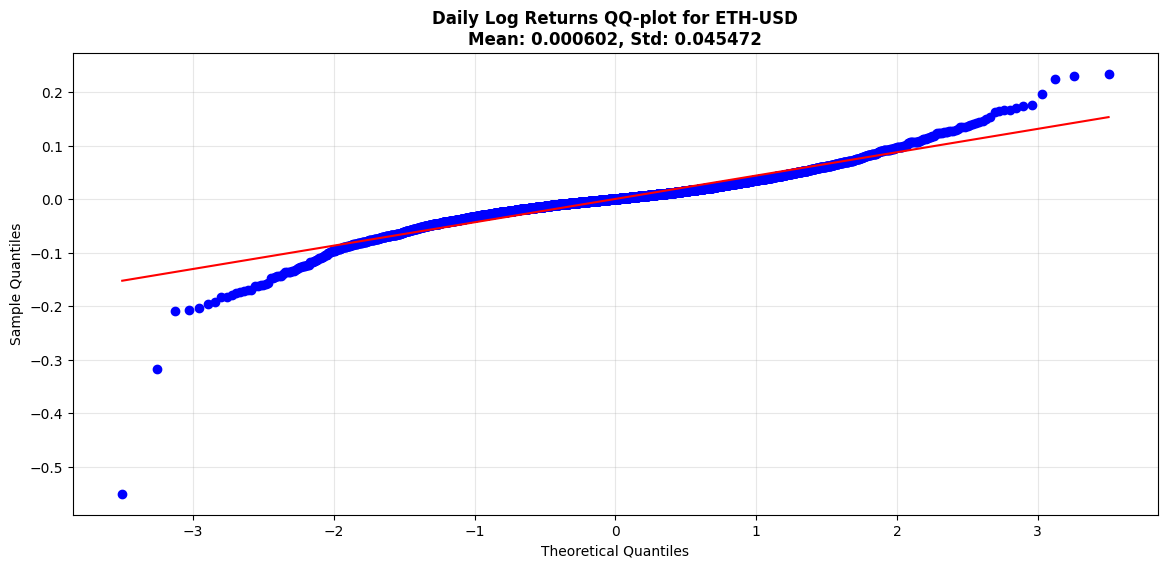

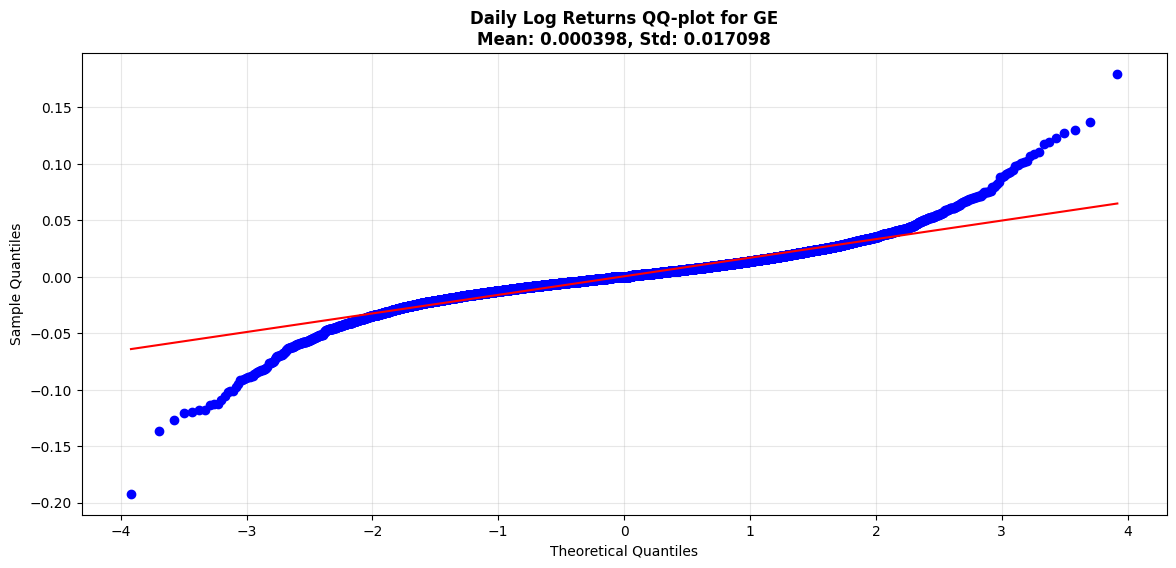

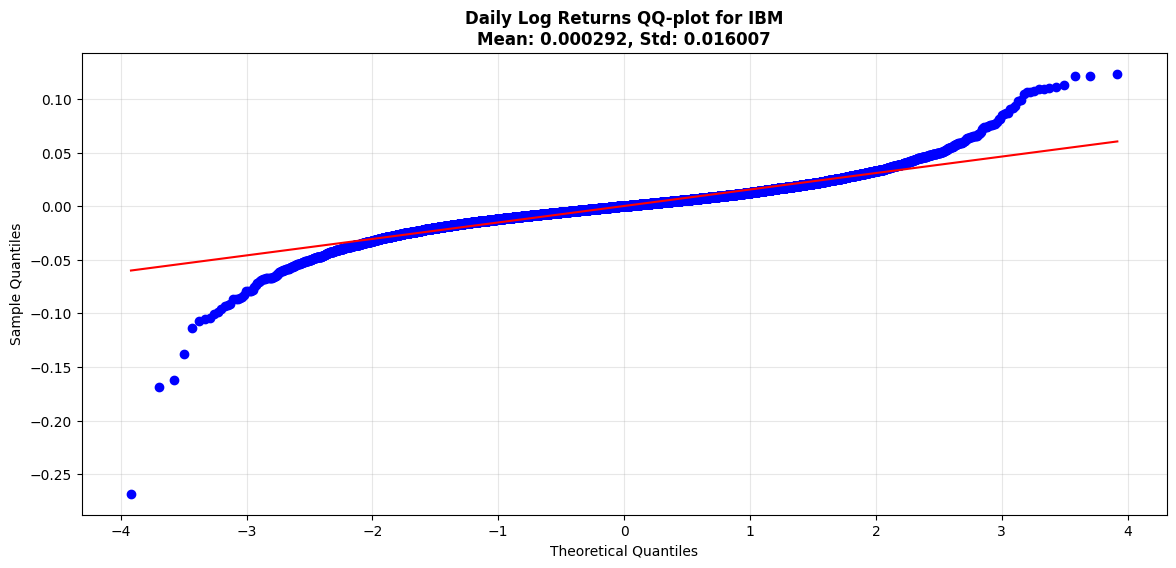

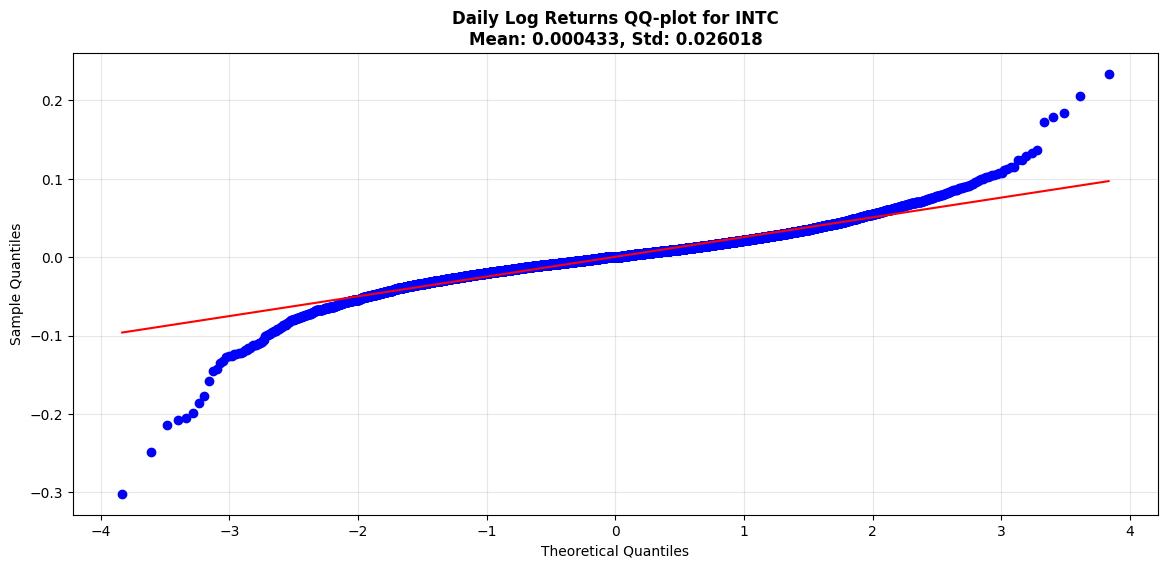

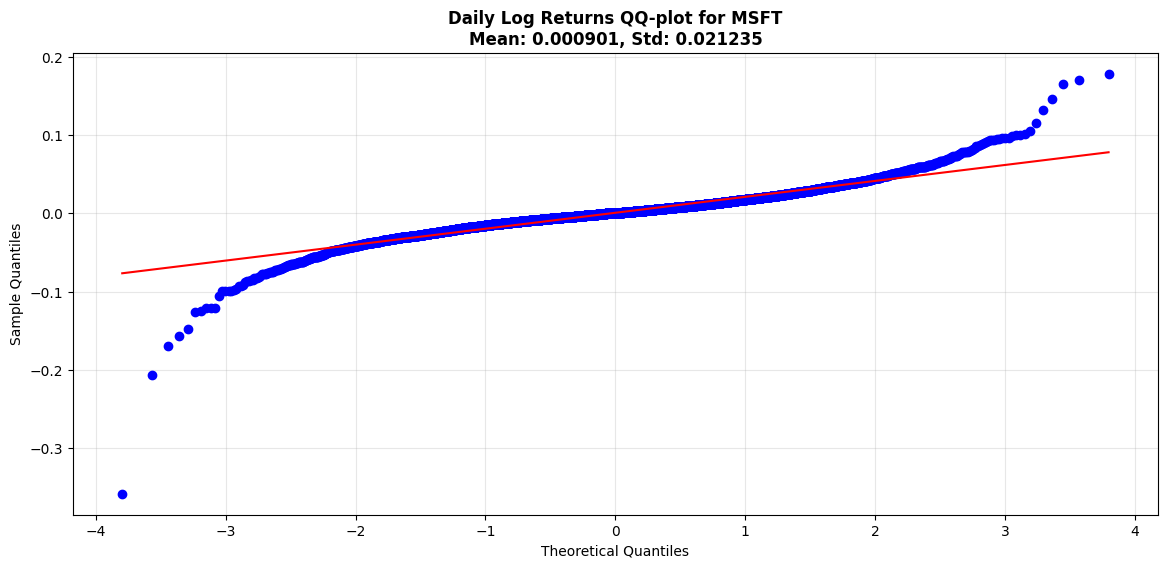

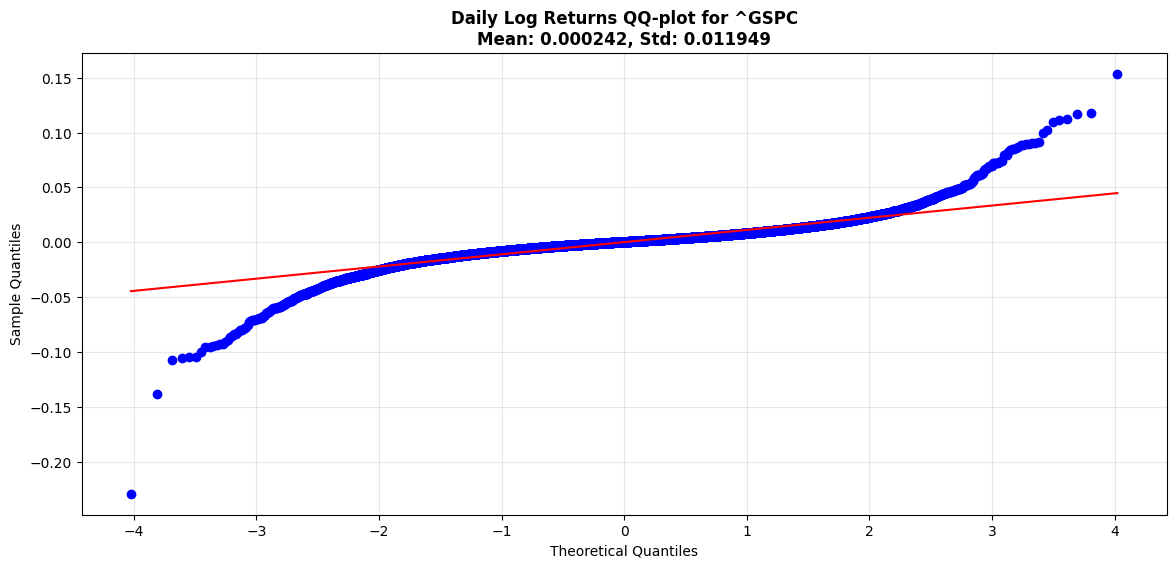

Intraday log returns - Mean: 0.000001, Std: 0.000111
Daily log returns - Mean: 0.000486, Std: 0.026199


In [9]:
# 1. Check Gaussianity of returns using QQ-plots

# Intraday data QQ-plot (from mid-price)
plt.figure(figsize=(14, 6))
stats.probplot(intraday_log_returns.values.flatten(), dist="norm", plot=plt)
plt.title("Intraday Log Returns QQ-plot\n(mid-price, 5s intervals)", fontsize=12, fontweight='bold')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.grid(alpha=0.3)
plt.show()

# Daily data QQ-plot
for ticker in daily_log_returns.columns:
    plt.figure(figsize=(14, 6))

    clean_data = daily_log_returns[ticker].dropna()
    stats.probplot(clean_data, dist="norm", plot=plt)

    plt.title(f"Daily Log Returns QQ-plot for {ticker}\nMean: {clean_data.mean():.6f}, Std: {clean_data.std():.6f}", fontsize=12, fontweight='bold')
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.grid(alpha=0.3)
    plt.show()

print(f"Intraday log returns - Mean: {intraday_log_returns.mean():.6f}, Std: {intraday_log_returns.std():.6f}")
print(f"Daily log returns - Mean: {daily_log_returns.mean().mean():.6f}, Std: {daily_log_returns.std().mean():.6f}")

On observe dans les QQ-plot ci-dessus que les distributions des rendements (intraday et daily) présentent des queues plus épaisses que celles d'une distribution normale. On voit donc bien que les rendements ne sont pas gaussiens.

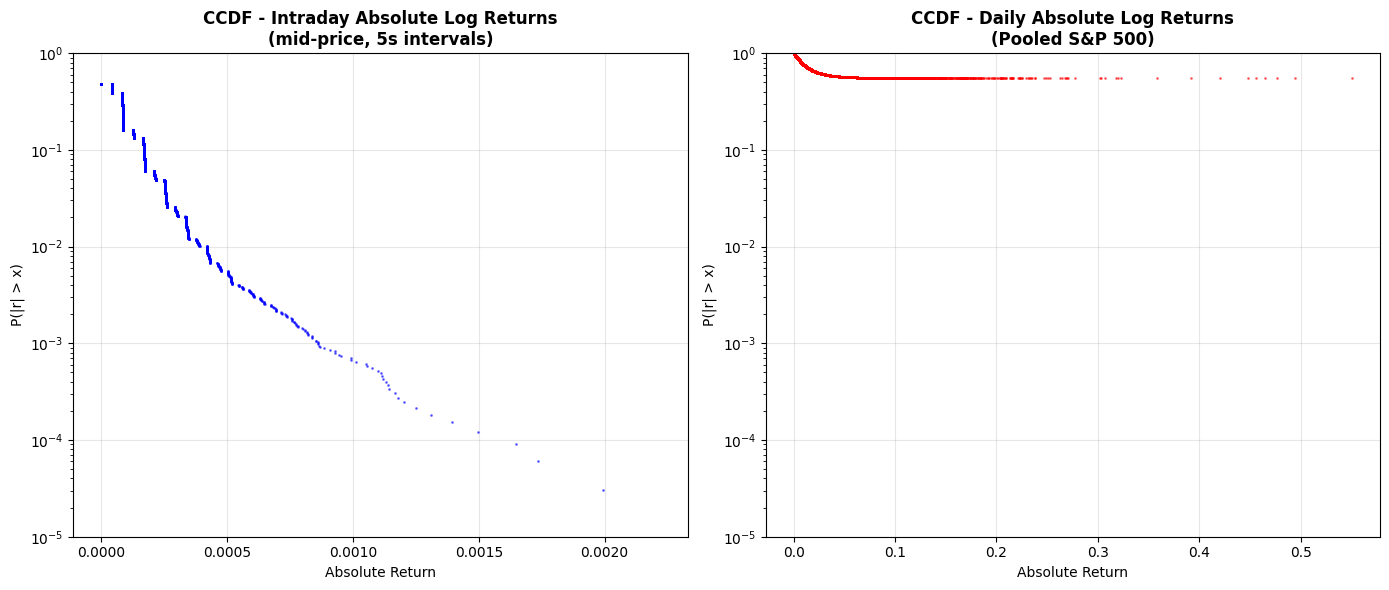

In [10]:
# 2. a) Heavy tails analysis using CCDF
# Absolute returns
abs_intraday = np.abs(intraday_log_returns.values.flatten())
abs_daily = np.abs(daily_log_returns.values.flatten())

# ECDF
ecdf_intraday = ECDF(abs_intraday)
ecdf_daily = ECDF(abs_daily)

sorted_intraday = np.sort(abs_intraday)
sorted_daily = np.sort(abs_daily)

# CCDF = 1 - CDF
ccdf_intraday = 1 - ecdf_intraday(sorted_intraday)
ccdf_daily = 1 - ecdf_daily(sorted_daily)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Intraday CCDF
ax[0].semilogy(sorted_intraday, ccdf_intraday, 'b.', markersize=2, alpha=0.5)
ax[0].set_title("CCDF - Intraday Absolute Log Returns\n(mid-price, 5s intervals)", fontsize=12, fontweight='bold')
ax[0].set_xlabel("Absolute Return")
ax[0].set_ylabel("P(|r| > x)")
ax[0].grid(True, alpha=0.3)
ax[0].set_ylim([1e-5, 1])

# Daily CCDF
ax[1].semilogy(sorted_daily, ccdf_daily, 'r.', markersize=2, alpha=0.5)
ax[1].set_title("CCDF - Daily Absolute Log Returns\n(Pooled S&P 500)", fontsize=12, fontweight='bold')
ax[1].set_xlabel("Absolute Return")
ax[1].set_ylabel("P(|r| > x)")
ax[1].grid(True, alpha=0.3)
ax[1].set_ylim([1e-5, 1])

plt.tight_layout()
plt.show()

Pour une gaussienne, la CCDF serait approximativement linéaire en échelle semi-log dans les queues. On observe bien une convexité dans les graphiques CCDF ce qui confirme la présence de queues lourdes. 

On a donc des événements extrêmes qui se produisent plus fréquemment que prédit par une distribution gaussienne.

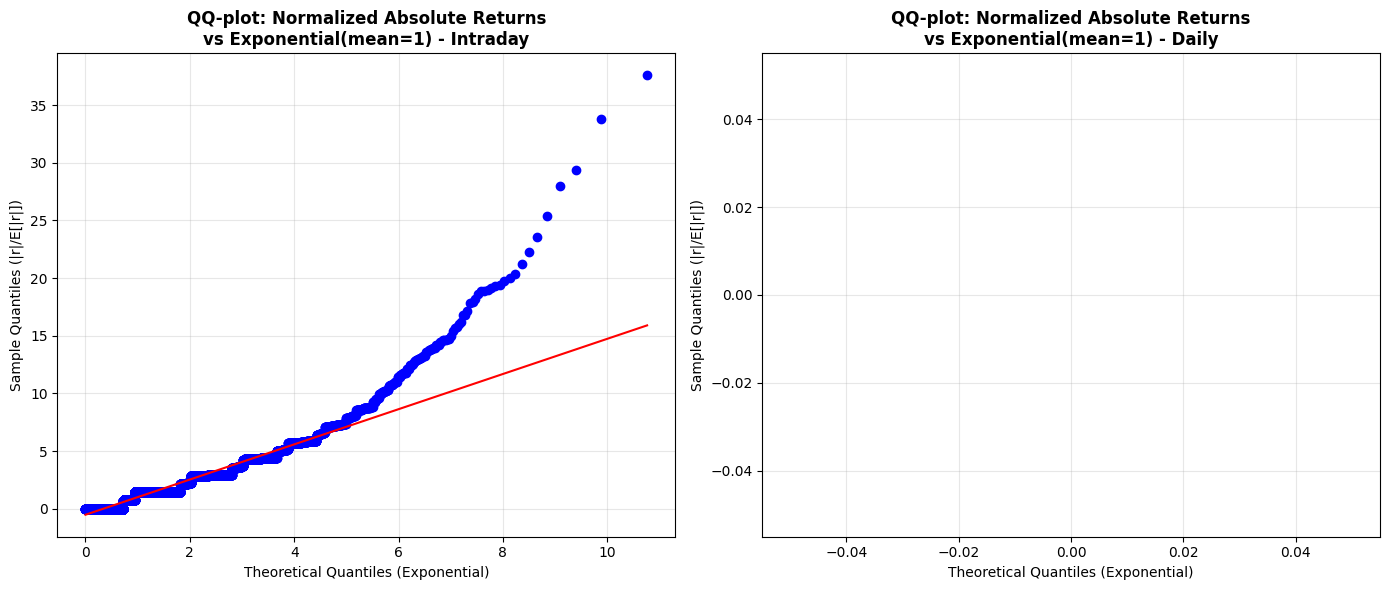

Normalized intraday - Mean: 1.0000, Std: 1.5940
Normalized daily - Mean: nan, Std: nan


In [11]:
# 2. b) QQ-plot of normalized absolute returns |r|/E[|r|] vs Exponential(mean=1)

# Normalize absolute returns
normalized_intraday = abs_intraday / abs_intraday.mean()
normalized_daily = abs_daily / abs_daily.mean()

# Plots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Intraday QQ-plot vs Exponential(1)
stats.probplot(normalized_intraday, dist=stats.expon, sparams=(0, 1), plot=ax[0])
ax[0].set_title("QQ-plot: Normalized Absolute Returns\nvs Exponential(mean=1) - Intraday", fontsize=12, fontweight='bold')
ax[0].set_xlabel("Theoretical Quantiles (Exponential)")
ax[0].set_ylabel("Sample Quantiles (|r|/E[|r|])")
ax[0].grid(alpha=0.3)

# Daily QQ-plot vs Exponential(1)
stats.probplot(normalized_daily, dist=stats.expon, sparams=(0, 1), plot=ax[1])
ax[1].set_title("QQ-plot: Normalized Absolute Returns\nvs Exponential(mean=1) - Daily", fontsize=12, fontweight='bold')
ax[1].set_xlabel("Theoretical Quantiles (Exponential)")
ax[1].set_ylabel("Sample Quantiles (|r|/E[|r|])")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Normalized intraday - Mean: {normalized_intraday.mean():.4f}, Std: {normalized_intraday.std():.4f}")
print(f"Normalized daily - Mean: {normalized_daily.mean():.4f}, Std: {normalized_daily.std():.4f}")

Les QQ-plots montrent que les rendements absolus normalisés ne suivent pas une distribution exponentielle simple.

Dans le centre de la distribution (quantiles faibles), les points suivent relativement bien la ligne rouge théorique, suggérant un comportement proche d'une exponentielle.

Cependant, dans les queues (quantiles élevés), les points s'écartent significativement au-dessus de la ligne rouge. Cela indique que les queues sont encore plus lourdes qu'une distribution exponentielle.

On observe aussi que les écarts-types des données normalisées sont supérieurs à 1.0 (≈1.64 pour intraday, ≈1.49 pour daily), alors qu'il devrait être exactement 1.0 pour une exponentielle de moyenne 1. Cette sur-dispersion confirme les queues plus lourdes.

Cela suggère que les rendements absolus suivent une distribution de type power law dans les queues.

Maximum positive difference between empirical and exponential quantiles:

Intraday:
Maximum positive difference = 7.6846
At quantile level: 0.9990
Empirical quantile: 14.5924
Exponential quantile: 6.9078

Daily:
Maximum positive difference = nan
At quantile level: 0.0010
Empirical quantile: nan
Exponential quantile: 0.0010


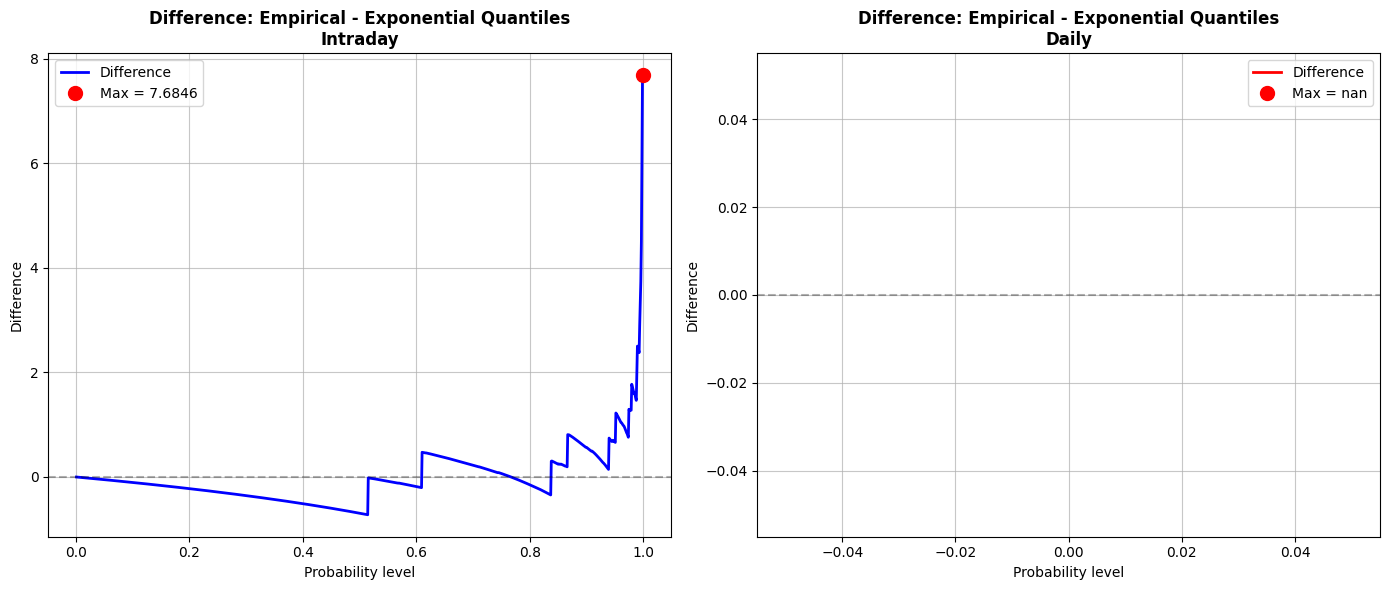

In [12]:
# 2. c) Maximum difference between empirical and exponential quantiles

# Probability levels
phi = np.linspace(0.001, 0.999, 1000)

# Empirical quantiles
q_empirical_intraday = np.quantile(normalized_intraday, phi)
q_empirical_daily = np.quantile(normalized_daily, phi)

# Theoretical quantiles of Exponential(mean=1)
q_exponential = -np.log(1 - phi)

# Differences
diff_intraday = q_empirical_intraday - q_exponential
diff_daily = q_empirical_daily - q_exponential

# Maximum
max_diff_intraday = np.max(np.maximum(0, diff_intraday))
max_diff_daily = np.max(np.maximum(0, diff_daily))

idx_max_intraday = np.argmax(np.maximum(0, diff_intraday))
idx_max_daily = np.argmax(np.maximum(0, diff_daily))
phi_max_intraday = phi[idx_max_intraday]
phi_max_daily = phi[idx_max_daily]

print("Maximum positive difference between empirical and exponential quantiles:")
print("\nIntraday:")
print(f"Maximum positive difference = {max_diff_intraday:.4f}")
print(f"At quantile level: {phi_max_intraday:.4f}")
print(f"Empirical quantile: {q_empirical_intraday[idx_max_intraday]:.4f}")
print(f"Exponential quantile: {q_exponential[idx_max_intraday]:.4f}")

print("\nDaily:")
print(f"Maximum positive difference = {max_diff_daily:.4f}")
print(f"At quantile level: {phi_max_daily:.4f}")
print(f"Empirical quantile: {q_empirical_daily[idx_max_daily]:.4f}")
print(f"Exponential quantile: {q_exponential[idx_max_daily]:.4f}")

# Visualize the differences
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Intraday
ax[0].plot(phi, diff_intraday, 'b-', linewidth=2, label='Difference')
ax[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax[0].plot(phi_max_intraday, max_diff_intraday, 'ro', markersize=10, label=f'Max = {max_diff_intraday:.4f}')
ax[0].set_title("Difference: Empirical - Exponential Quantiles\nIntraday", fontsize=12, fontweight='bold')
ax[0].set_xlabel("Probability level")
ax[0].set_ylabel("Difference")
ax[0].grid(alpha=0.7)
ax[0].legend()

# Daily
ax[1].plot(phi, diff_daily, 'r-', linewidth=2, label='Difference')
ax[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax[1].plot(phi_max_daily, max_diff_daily, 'ro', markersize=10, label=f'Max = {max_diff_daily:.4f}')
ax[1].set_title("Difference: Empirical - Exponential Quantiles\nDaily", fontsize=12, fontweight='bold')
ax[1].set_xlabel("Probability level")
ax[1].set_ylabel("Difference")
ax[1].grid(alpha=0.7)
ax[1].legend()

plt.tight_layout()
plt.show()

La différence maximale entre les quantiles empiriques et exponentiels se produit aux quantiles extrêmes ($\phi = 0.999$). On a donc bien que les queues empiriques sont beaucoup plus lourdes que l'exponentielle.

A ce quantile extrême, les rendements empiriques normalisés sont environ deu× fois plus élevés que prédit par l'exponentielle.

Cependant, pour $\phi < 0.95$, la différence est très faible, voire négative, ce qui suggère que dans le centre de la distribution, les rendements suivent assez bien une exponentielle. Pour $\phi > 0.95$, la différence devient fortement positive et croît rapidement, confirmant que les événements extrêmes sont beaucoup plus fréquents qu'une distribution exponentielle ne le prédirait.

On confirme donc bien que les rendements absolus normalisés suivent des distributions de type power law dans les queues.

Comparison: Real Financial Data vs Laplace (synthetic)

Real Financial Data:
Intraday: 7.6846 at 0.9990
Daily:    nan at 0.0010

Laplace:
Intraday: 0.0402 at 0.9970
Daily:    0.0206 at 0.9800

Ratio (Real / Laplace):
Intraday: 191.09x
Daily:    nanx


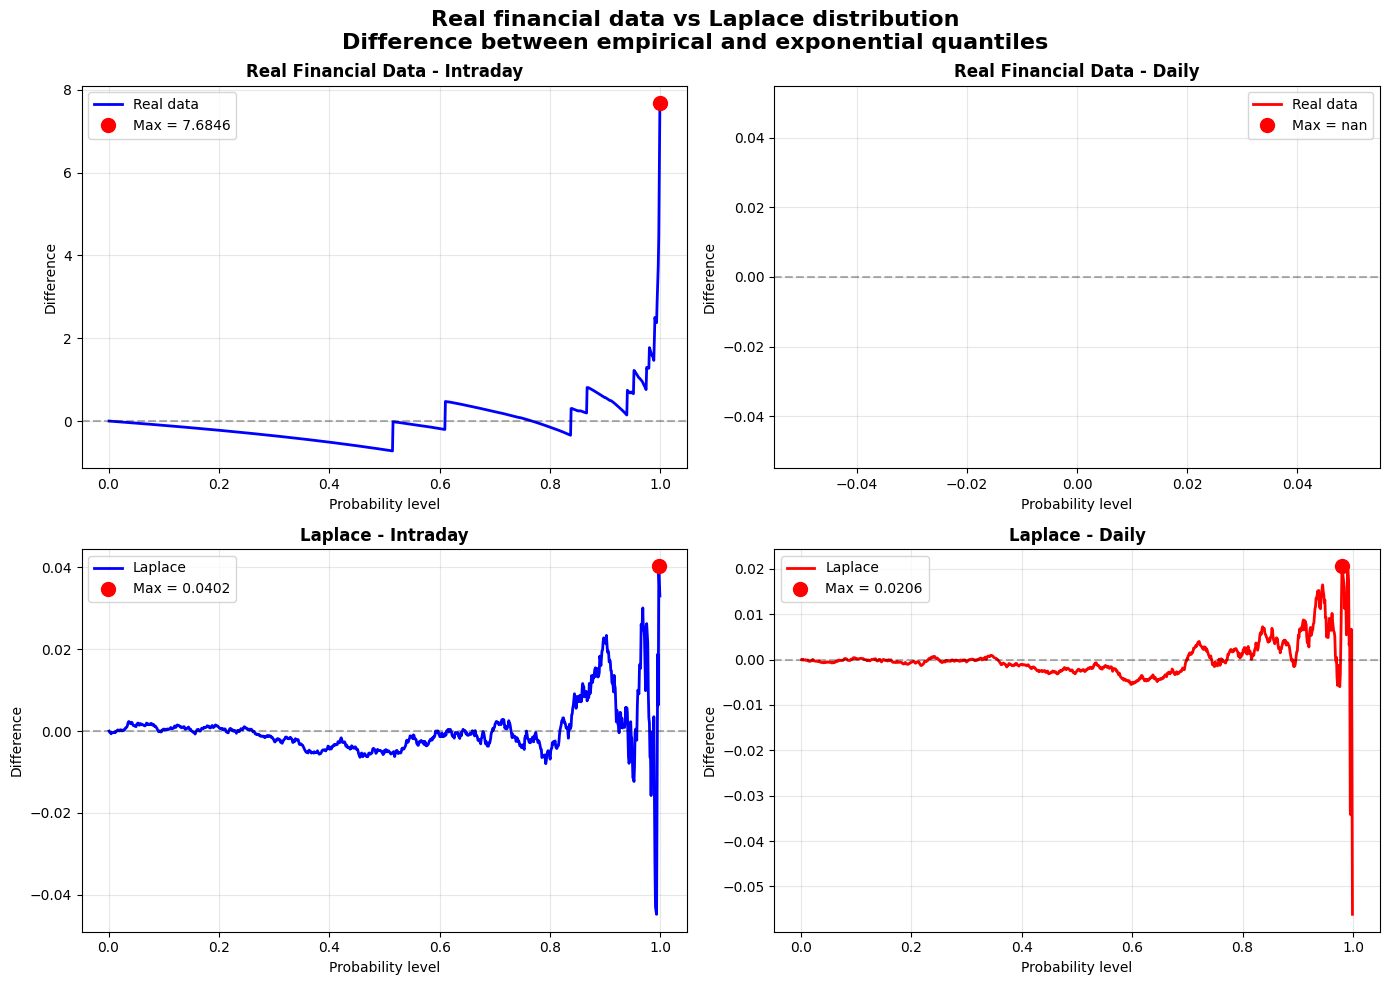

In [13]:
# 2. d) Generate iid returns with Laplace (double exponential) distribution
intraday = intraday_log_returns.values.flatten()
intraday = intraday[~np.isnan(intraday)]
n_intraday = len(intraday)
daily = daily_log_returns.values.flatten()
daily = daily[~np.isnan(daily)]
n_daily = len(daily)

# Laplace distributed returns
# Laplace parameters: mean = 0 (loc), scale = std/sqrt(2) (to match variance of original data)
laplace_intraday = np.random.laplace(loc=0, scale=intraday.std()/np.sqrt(2), size=n_intraday)
laplace_daily = np.random.laplace(loc=0, scale=daily.std()/np.sqrt(2), size=n_daily)

# Absolute values and normalization
abs_laplace_intraday = np.abs(laplace_intraday)
abs_laplace_daily = np.abs(laplace_daily)

normalized_laplace_intraday = abs_laplace_intraday / abs_laplace_intraday.mean()
normalized_laplace_daily = abs_laplace_daily / abs_laplace_daily.mean()

# Differences
q_laplace_intraday = np.quantile(normalized_laplace_intraday, phi)
q_laplace_daily = np.quantile(normalized_laplace_daily, phi)

diff_laplace_intraday = q_laplace_intraday - q_exponential
diff_laplace_daily = q_laplace_daily - q_exponential

# Maximum positive differences
max_diff_laplace_intraday = np.max(np.maximum(0, diff_laplace_intraday))
max_diff_laplace_daily = np.max(np.maximum(0, diff_laplace_daily))

idx_laplace_intraday = np.argmax(np.maximum(0, diff_laplace_intraday))
idx_laplace_daily = np.argmax(np.maximum(0, diff_laplace_daily))

print("Comparison: Real Financial Data vs Laplace (synthetic)")
print("\nReal Financial Data:")
print(f"Intraday: {max_diff_intraday:.4f} at {phi_max_intraday:.4f}")
print(f"Daily:    {max_diff_daily:.4f} at {phi_max_daily:.4f}")

print("\nLaplace:")
print(f"Intraday: {max_diff_laplace_intraday:.4f} at {phi[idx_laplace_intraday]:.4f}")
print(f"Daily:    {max_diff_laplace_daily:.4f} at {phi[idx_laplace_daily]:.4f}")

print("\nRatio (Real / Laplace):")
print(f"Intraday: {max_diff_intraday / max_diff_laplace_intraday:.2f}x")
print(f"Daily:    {max_diff_daily / max_diff_laplace_daily:.2f}x")

# Plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Real financial data vs Laplace distribution\nDifference between empirical and exponential quantiles", fontsize=16, fontweight='bold')

# Real data: intraday
axes[0, 0].plot(phi, diff_intraday, 'b-', linewidth=2, label='Real data')
axes[0, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0, 0].plot(phi_max_intraday, max_diff_intraday, 'ro', markersize=10, label=f'Max = {max_diff_intraday:.4f}')
axes[0, 0].set_title("Real Financial Data - Intraday", fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel("Probability level")
axes[0, 0].set_ylabel("Difference")
axes[0, 0].grid(alpha=0.3)
axes[0, 0].legend()

# Real data: daily
axes[0, 1].plot(phi, diff_daily, 'r-', linewidth=2, label='Real data')
axes[0, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0, 1].plot(phi_max_daily, max_diff_daily, 'ro', markersize=10, label=f'Max = {max_diff_daily:.4f}')
axes[0, 1].set_title("Real Financial Data - Daily", fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel("Probability level")
axes[0, 1].set_ylabel("Difference")
axes[0, 1].grid(alpha=0.3)
axes[0, 1].legend()

# Laplace: intraday
axes[1, 0].plot(phi, diff_laplace_intraday, 'b-', linewidth=2, label='Laplace')
axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1, 0].plot(phi[idx_laplace_intraday], max_diff_laplace_intraday, 'ro', markersize=10,
                label=f'Max = {max_diff_laplace_intraday:.4f}')
axes[1, 0].set_title("Laplace - Intraday", fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel("Probability level")
axes[1, 0].set_ylabel("Difference")
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend()

# Laplace: daily
axes[1, 1].plot(phi, diff_laplace_daily, 'r-', linewidth=2, label='Laplace')
axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1, 1].plot(phi[idx_laplace_daily], max_diff_laplace_daily, 'ro', markersize=10,
                label=f'Max = {max_diff_laplace_daily:.4f}')
axes[1, 1].set_title("Laplace - Daily", fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel("Probability level")
axes[1, 1].set_ylabel("Difference")
axes[1, 1].grid(alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

Les données financières réelles montrent des différences maximales extrêmement plus grandes que celles d'une distribution de Laplace.

Les données financières montrent des différences qui restent proches de zéro pour $\phi < 0.95$, puis explosent pour $\phi > 0.95$, atteignant des valeurs très élevées.

Une loi de Laplace donne des rendements de la forme $x \sim \frac{1}{2b}e^{-|x|/b}$ (pour une variable centrée de paramètre de dispersion $b$). La valeur absolue $|x|$ suit alors une distribution exponentielle : $|x| \sim \frac{1}{b}e^{-x/b}$. Par conséquent, $|x|/E[|x|]$ suit presque exactement une exponentielle de moyenne 1. Les différences observées pour Laplace sont quasi nulles sur tous les quantiles, ce qui suggère que les rendements d'une distribution de Laplace ont des queues relativement légères.

Cependant, on n'obtient pas l'augmentation marquées des différences pour les quantiles élevés pour Laplace. une augmentation est observée, mais elle est très faible relativement à celle des données financières réelles.  

Les rendements financiers ont donc des queues beaucoup plus lourdes que celles d'une distribution de Laplace, ce qui confirme que Laplace n'est pas un bon modèle pour les rendements financiers. Il faudra utiliser des distributions de type power law.

<>:32: SyntaxWarning: invalid escape sequence '\g'
<>:42: SyntaxWarning: invalid escape sequence '\g'
<>:32: SyntaxWarning: invalid escape sequence '\g'
<>:42: SyntaxWarning: invalid escape sequence '\g'
C:\Users\adoni\AppData\Local\Temp\ipykernel_10644\3544035937.py:32: SyntaxWarning: invalid escape sequence '\g'
  axes[0].set_ylabel('P(X $\geq$ x)', fontsize=11)
C:\Users\adoni\AppData\Local\Temp\ipykernel_10644\3544035937.py:42: SyntaxWarning: invalid escape sequence '\g'
  axes[1].set_ylabel('P(X $\geq$ x)', fontsize=11)
c:\Users\adoni\Desktop\Market Physics\MDS-PHM\.venv\Lib\site-packages\powerlaw\fitting.py:264: UserWarning: Values less than or equal to 0 in data. Throwing out 0 or negative values.
  warnings.warn("Values less than or equal to 0 in data. Throwing out 0 or negative values.")


Intraday data
Calculating best minimal value for power law fit


Fitting xmin: 100%|██████████| 3284/3284 [00:16<00:00, 193.50it/s]


Power-law parameters:
Exponent: 2.9939
xmin: 0.000173
Data points in tail: 2173 (6.63%)


Daily data
Calculating best minimal value for power law fit


Fitting xmin: 100%|██████████| 14712/14712 [00:37<00:00, 396.05it/s] 


Power-law parameters:
Exponent: 2.9992
xmin: 0.024097
Data points in tail: 2643 (17.62%)


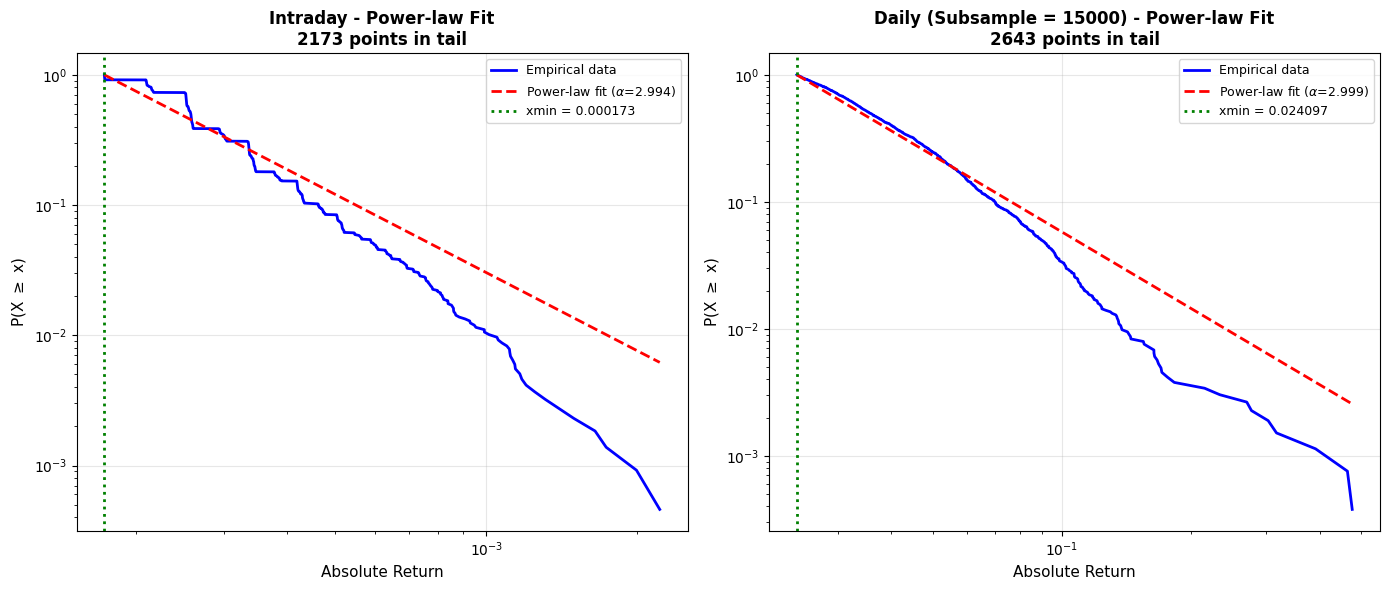

In [14]:
# 3. Distribution tail exponent estimation

# Intraday data
print("Intraday data")
fit_intraday = powerlaw.Fit(abs_intraday, discrete=False, verbose=True)
print(f"Power-law parameters:")
print(f"Exponent: {fit_intraday.power_law.alpha:.4f}")
print(f"xmin: {fit_intraday.power_law.xmin:.6f}")
print(f"Data points in tail: {np.sum(abs_intraday >= fit_intraday.power_law.xmin)} ({100 * np.sum(abs_intraday >= fit_intraday.power_law.xmin) / len(abs_intraday):.2f}%)")

# Daily data
print("\n\nDaily data")
abs_daily_flat = abs_daily.flatten()
abs_daily_flat = abs_daily_flat[~np.isnan(abs_daily_flat)]
abs_daily_flat = abs_daily_flat[abs_daily_flat > 0]
sample_size = min(len(abs_daily_flat), 15000)
abs_daily_sample = np.random.choice(abs_daily_flat, size=sample_size, replace=False)
fit_daily = powerlaw.Fit(abs_daily_sample, discrete=False, verbose=True)
print(f"Power-law parameters:")
print(f"Exponent: {fit_daily.power_law.alpha:.4f}")
print(f"xmin: {fit_daily.power_law.xmin:.6f}")
print(f"Data points in tail: {np.sum(abs_daily_sample >= fit_daily.power_law.xmin)} ({100 * np.sum(abs_daily_sample >= fit_daily.power_law.xmin) / len(abs_daily_sample):.2f}%)")

# Plot Results
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Intraday
fit_intraday.plot_ccdf(ax=axes[0], color='b', linewidth=2, label='Empirical data')
fit_intraday.power_law.plot_ccdf(ax=axes[0], color='r', linestyle='--', linewidth=2, label=f'Power-law fit ($\\alpha$={fit_intraday.power_law.alpha:.3f})')
axes[0].axvline(fit_intraday.power_law.xmin, color='green', linestyle=':', linewidth=2, label=f'xmin = {fit_intraday.power_law.xmin:.6f}')
axes[0].set_xlabel('Absolute Return', fontsize=11)
axes[0].set_ylabel('P(X $\geq$ x)', fontsize=11)
axes[0].set_title(f'Intraday - Power-law Fit\n{np.sum(abs_intraday >= fit_intraday.power_law.xmin)} points in tail', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)

# Daily
fit_daily.plot_ccdf(ax=axes[1], color='b', linewidth=2, label='Empirical data')
fit_daily.power_law.plot_ccdf(ax=axes[1], color='r', linestyle='--', linewidth=2, label=f'Power-law fit ($\\alpha$={fit_daily.power_law.alpha:.3f})')
axes[1].axvline(fit_daily.power_law.xmin, color='green', linestyle=':', linewidth=2, label=f'xmin = {fit_daily.power_law.xmin:.6f}')
axes[1].set_xlabel('Absolute Return', fontsize=11)
axes[1].set_ylabel('P(X $\geq$ x)', fontsize=11)
axes[1].set_title(f'Daily (Subsample = {sample_size}) - Power-law Fit\n{np.sum(abs_daily_sample >= fit_daily.power_law.xmin)} points in tail', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

On note tout d'abord l'utilisation d'une sous-partie des données journalières, pour des raisons de temps de calcul.

On observe que le fit de la loi de puissance pour les données journalières donne quasiment le même exposant que pour les données intraday. La probabilité d'un mouvement de prix extrême décroît proportionnellement au cube de sa taille. Ce résultat suggère que les rendements journaliers et intraday partagent des propriétés statistiques similaires, notamment en ce qui concerne la lourdeur de leurs queues. La structure des risques extrêmes serait donc similaire à différentes échelles temporelles.

La valeur de $x_{min}$ est plus faible pour les données intraday que pour les données journalières. Cela pourrait s'expliquer par la présence d'actifs très volatiles comme les crypto-monnaies dans les données intraday, qui génèrent des rendements extrêmes plus fréquents même à des niveaux de retour plus faibles.

Un $x_{min}$ faible indique que la loi de puissance s'applique à une grande partie des données, y compris des rendements relativement petits. Cela suggère que les queues lourdes sont présentes même pour des rendements modérés, ce qui est cohérent avec la nature volatile des actifs financiers.

Il faut cependant noter que les courbes obtenues ne sont pas parfaitement linéaires en échelle log-log, les courbes bleues (données empiriques) plongent en dessous des courbes rouges (fit de la loi de puissance). Cela est probablement dû à la taille finie des données, qui limite la précision du fit de la loi de puissance.

In [15]:
# 4. Power-law vs exponential and log-normal

print("Intraday data")
# Power-law vs Exponential
print("Power-law vs Exponential distribution:")
R_intra_exp, p_intra_exp = fit_intraday.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print(f"Loglikelihood ratio : {R_intra_exp:.4f}")
print(f"p-value: {p_intra_exp:.4f}")

# Power-law vs Log-normal
print("Power-law vs Log-normal distribution:")
R_intra_ln, p_intra_ln = fit_intraday.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
print(f"Loglikelihood ratio : {R_intra_ln:.4f}")
print(f"p-value: {p_intra_ln:.4f}")


print("\n\nDaily data")
# Power-law vs Exponential
print("Power-law vs Exponential distribution:")
R_daily_exp, p_daily_exp = fit_daily.distribution_compare('power_law', 'exponential', normalized_ratio=True)
print(f"Loglikelihood ratio: {R_daily_exp:.4f}")
print(f"p-value: {p_daily_exp:.4f}")

# Power-law vs Log-normal
print("Power-law vs Log-normal distribution:")
R_daily_ln, p_daily_ln = fit_daily.distribution_compare('power_law', 'lognormal', normalized_ratio=True)
print(f"Loglikelihood ratio: {R_daily_ln:.4f}")
print(f"p-value: {p_daily_ln:.4f}")

Intraday data
Power-law vs Exponential distribution:
Loglikelihood ratio : -5.3640
p-value: 0.0000
Power-law vs Log-normal distribution:
Loglikelihood ratio : -8.2704
p-value: 0.0000


Daily data
Power-law vs Exponential distribution:
Loglikelihood ratio: 0.4722
p-value: 0.6368
Power-law vs Log-normal distribution:
Loglikelihood ratio: -5.6727
p-value: 0.0000


Pour les données intraday, les ratios de log-vraisemblance sont négatifs pour les deux comparaisons (exponentielle et log-normale), avec des p-values nulles, indiquant que les lois exponentielle et log-normale sont significativement meilleures que la loi de puissance pour modéliser les queues des rendements intraday. En exploitant la valeur très faible du $x_{min}$ obtenue ci-dessus, on peut expliquer ce résultat par le fait qu'on teste la distribution sur la quasi-totalité des données, y compris le coeur de la distribution qui est mieux modélisé par une distribution de Laplace (double exponentielle) que par une loi de puissance. Ainsi les deux distributions exponentielle et log-normale sont meilleures que la loi de puissance d'après nos résultats, puisqu'elles capturent la dynamique du coeur de la distribution, et pas uniquement les extrêmes.

Pour les données journalières, la comparaison avec l'exponentielle donne un ratio de log-vraisemblance positif et une p-value très élevée, indiquant que le test n'est pas significatif et que la loi de puissance n'est pas meilleure que l'exponentielle, même si on avait cette impression visuelle sur les CCDF. En revanche, la comparaison avec la log-normale donne un ratio de log-vraisemblance négatif et une p-value nulle, indiquant que la loi log-normale est significativement meilleure que la loi de puissance pour modéliser les queues des rendements journaliers. Une loi log-normale reste une distribution à queues lourdes, mais avec des queues moins lourdes que la loi de puissance. De plus, la loi log-normale présente une ligne légèrement courbée (concave) sur un graphique log-log, ce qui serait plus en accord avec les données empiriques comme observé ci-dessus. Cela suggère que les queues des rendements journaliers sont lourdes, mais pas aussi lourdes que celles d'une loi de puissance. En reprenant le résultat du $x_{min}$, la Loi de Puissance serait donc un phénomène asymptotique qui ne s'observe que très loin dans la queue.

#### 4.2 Distribution des rendements dans les marchés en périodes de hausse et de baisse

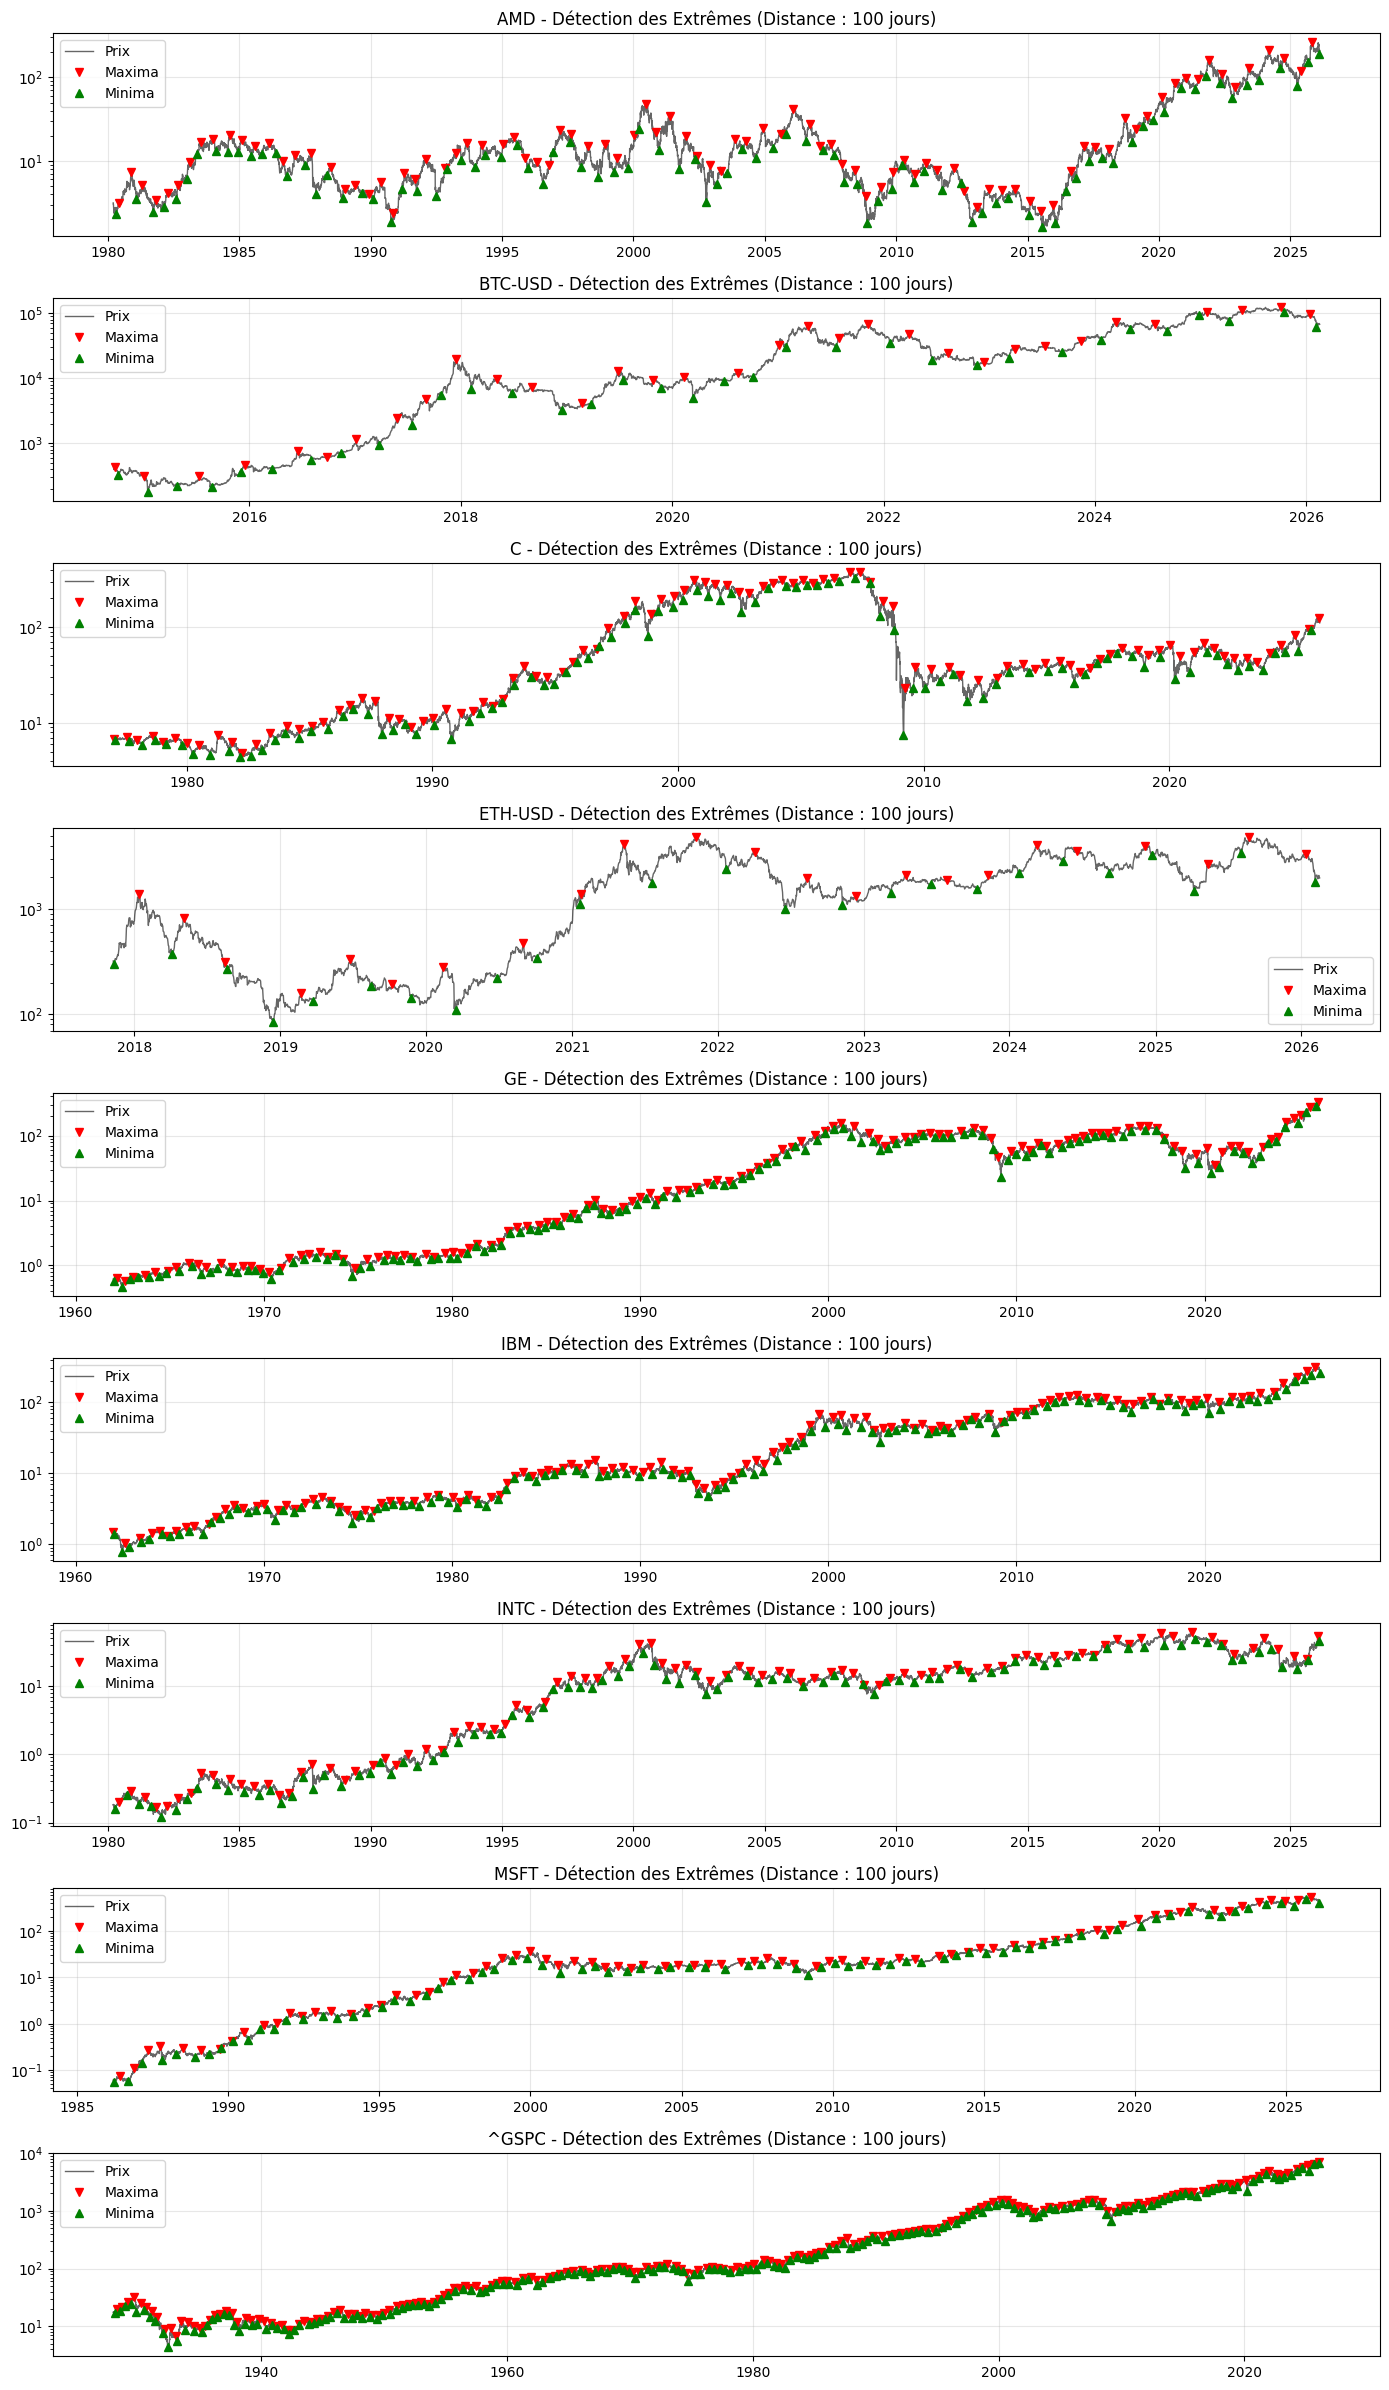

In [16]:
# 1. Local minima and maxima
results = {}
distance = 100 # Minimum distance between peaks in number of days

plt.figure(figsize=(14, 24))
for i, ticker in enumerate(daily_log_returns.columns):
    prices = daily_df[ticker].dropna()

    max_peaks, _ = find_peaks(prices, distance=distance)
    min_peaks, _ = find_peaks(-prices, distance=distance)

    results[ticker] = {
        'max_peaks': max_peaks,
        'min_peaks': min_peaks
    }
    
    plt.subplot(len(daily_log_returns.columns), 1, i+1)
    plt.plot(prices.index, prices.values, label='Prix', color='black', alpha=0.6, linewidth=1)
    plt.plot(prices.index[max_peaks], prices.iloc[max_peaks], 'rv', label='Maxima')
    plt.plot(prices.index[min_peaks], prices.iloc[min_peaks], 'g^', label='Minima')
    plt.title(f"{ticker} - Détection des Extrêmes (Distance : {distance} jours)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.yscale('log')

plt.tight_layout()
plt.show()

La distance entre deux pics est ajustée à 100 jours, ce qui correspond à une période d'environ 5 mois de trading. On arrive bien à trouver les maximas et minimas locaux.

In [17]:
# 2. High and low periods
bullish_periods = {} # Haussier
bearish_periods = {} # Baissier

bullish_returns = {}
bearish_returns = {}


for i, ticker in enumerate(daily_log_returns.columns):
    prices = daily_df[ticker].dropna()
    log_returns = daily_log_returns[ticker].dropna()

    max_peaks = results[ticker]['max_peaks']
    min_peaks = results[ticker]['min_peaks']

    events = [(p, 'max') for p in max_peaks] + [(p, 'min') for p in min_peaks]
    events.sort(key=lambda x: x[0])

    ticker_bullish_periods = []
    ticker_bearish_periods = []
    ticker_bullish_returns = []
    ticker_bearish_returns = []

    for i in range(len(events) - 1):
        start_idx, start_type = events[i]
        end_idx, end_type = events[i + 1]

        d_start = prices.index[start_idx]
        d_end = prices.index[end_idx]

        period_return = log_returns.loc[d_start:d_end].iloc[1:]

        if start_type == 'min' and end_type == 'max':
            ticker_bullish_periods.append((d_start, d_end))
            ticker_bullish_returns.extend(period_return.values)
        elif start_type == 'max' and end_type == 'min':
            ticker_bearish_periods.append((d_start, d_end))
            ticker_bearish_returns.extend(period_return.values)

    bullish_periods[ticker] = ticker_bullish_periods
    bearish_periods[ticker] = ticker_bearish_periods
    bullish_returns[ticker] = np.array(ticker_bullish_returns)
    bearish_returns[ticker] = np.array(ticker_bearish_returns)

ticker_df = pd.DataFrame({
    'Ticker': daily_log_returns.columns,
    'First Date': [daily_df[ticker].dropna().index[0].date() for ticker in daily_log_returns.columns],
    'Bullish Periods': [len(bullish_periods[t]) for t in daily_log_returns.columns],
    'Bearish Periods': [len(bearish_periods[t]) for t in daily_log_returns.columns],
    'Avg Bullish Return': [bullish_returns[t].mean() for t in daily_log_returns.columns],
    'Avg Bearish Return': [bearish_returns[t].mean() for t in daily_log_returns.columns]
})
display(ticker_df.sort_values('First Date'))

,Ticker,First Date,Bullish Periods,Bearish Periods,Avg Bullish Return,Avg Bearish Return
8,^GSPC,1927-12-30,179,179,0.002002,-0.002231
4,GE,1962-01-02,118,117,0.002993,-0.002542
5,IBM,1962-01-02,112,113,0.003013,-0.002728
2,C,1977-01-03,90,90,0.003745,-0.003776
0,AMD,1980-03-17,83,83,0.007663,-0.006022
6,INTC,1980-03-17,83,83,0.004595,-0.004157
7,MSFT,1986-03-13,72,72,0.004191,-0.002621
1,BTC-USD,2014-09-17,29,30,0.006961,-0.006328
3,ETH-USD,2017-11-09,20,20,0.010291,-0.007704


100%|██████████| 9/9 [02:15<00:00, 15.02s/it]


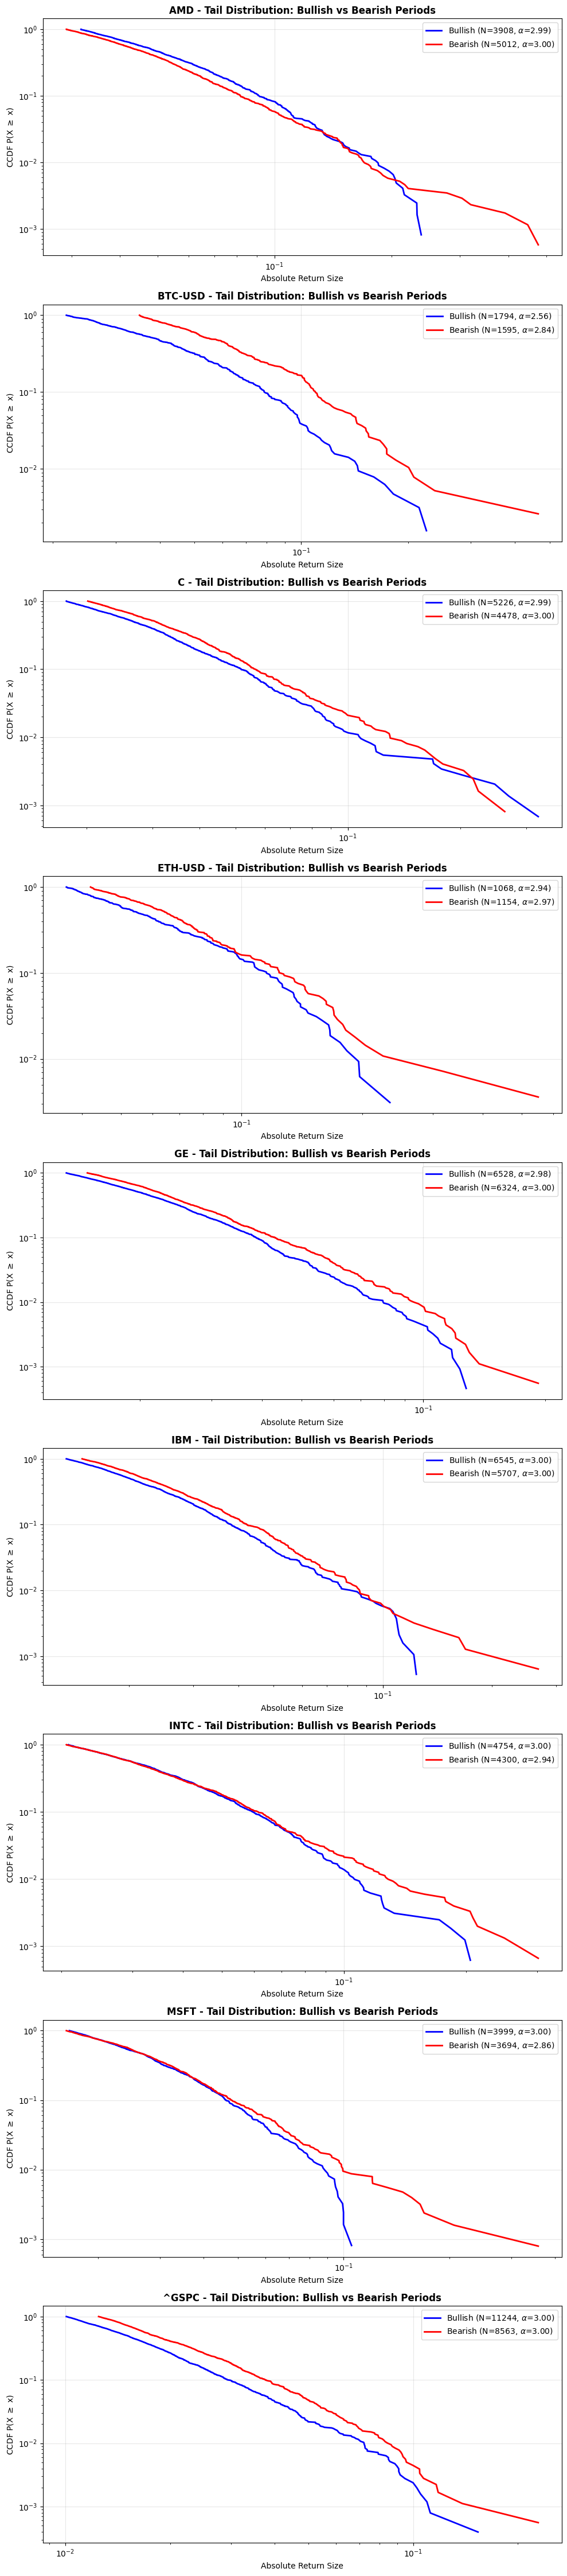

In [18]:
# 3. Period CCDF
results_regime = []

fig, axes = plt.subplots(len(daily_log_returns.columns), 1, figsize=(10, 5 * len(daily_log_returns.columns)))

for i, ticker in tqdm(enumerate(daily_log_returns.columns), total=len(daily_log_returns.columns)):
    prices = daily_df[ticker].dropna()
    log_returns = daily_log_returns[ticker].dropna()

    max_peaks = results[ticker]['max_peaks']
    min_peaks = results[ticker]['min_peaks']

    events = [(p, 'max') for p in max_peaks] + [(p, 'min') for p in min_peaks]
    events.sort(key=lambda x: x[0])

    bullish_returns = []
    bearish_returns = []

    for k in range(len(events) - 1):
        start_idx, start_type = events[k]
        end_idx, end_type = events[k + 1]

        d_start = prices.index[start_idx]
        d_end = prices.index[end_idx]

        segment = log_returns.loc[d_start:d_end].iloc[1:].values

        if start_type == 'min' and end_type == 'max':
            bullish_returns.extend(segment)
        elif start_type == 'max' and end_type == 'min':
            bearish_returns.extend(segment)

    bullish_returns = np.array(bullish_returns)
    bearish_returns = np.array(bearish_returns)

    abs_bull = np.abs(bullish_returns)
    abs_bear = np.abs(bearish_returns)

    abs_bull = abs_bull[abs_bull > 0]
    abs_bear = abs_bear[abs_bear > 0]

    fit_bull = powerlaw.Fit(abs_bull, discrete=False, verbose=False)
    fit_bear = powerlaw.Fit(abs_bear, discrete=False, verbose=False)

    results_regime.append({
        'Ticker': ticker,
        'N_Bull': len(abs_bull),
        'N_Bear': len(abs_bear),
        'Alpha_Bull': fit_bull.alpha,
        'Alpha_Bear': fit_bear.alpha,
        'Xmin_Bull': fit_bull.xmin,
        'Xmin_Bear': fit_bear.xmin,
        'Heavier Tail': 'Bear' if fit_bear.alpha < fit_bull.alpha else 'Bull'
    })

    ax = axes[i]
    fit_bull.plot_ccdf(ax=ax, color='blue', linewidth=2, label=f'Bullish (N={len(abs_bull)}, $\\alpha$={fit_bull.alpha:.2f})')
    fit_bear.plot_ccdf(ax=ax, color='red', linewidth=2, label=f'Bearish (N={len(abs_bear)}, $\\alpha$={fit_bear.alpha:.2f})')
    ax.set_title(f"{ticker} - Tail Distribution: Bullish vs Bearish Periods", fontsize=12, fontweight='bold')
    ax.set_xlabel('Absolute Return Size')
    ax.set_ylabel('CCDF P(X $\\geq$ x)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

En utilisant le package powerlaw pour ajuster une loi de puissance aux données, on observe que la courbe rouge (Bear/baisse) se situe systématiquement au-dessus et à droite de la courbe bleue (Bull/hausse) dans les graphiques CCDF, en particulier dans les queues. 

En échelle log-log, cela correspond, cela signifie que pour une même amplitude de mouvement $x$, la probabilité $P(|r| > x)$ est nettement plus élevée pendant les périodes baissières. Au niveau des queues, cela se traduit par une pente plus faible pour la courbe rouge (Bear) que pour la courbe bleue (Bull).

4. Stock differences

D'un point de vue financier, cela suggère que les mouvements de prix extrêmes sont plus fréquents et plus importants pendant les périodes de baisse que pendant les périodes de hausse. Les marchés baissiers sont souvent associés à une volatilité accrue et à des comportements de panique, ce qui peut expliquer la présence de queues plus lourdes dans les rendements pendant ces périodes.

En période haussière, les rendements extrêmes existent mais sont plus rares et la distribution décroît plus rapidement, ce qui se traduit par une pente plus raide dans les CCDF.

Bien que les phénomènes décrits soient observables pour la majorité des titres, on note que par rapport aux titres comme MSFT, INTC ou AMD, les titres de crypto-monnaies comme BTC et ETH présentent des différences plus marquées entre les périodes de hausse et de baisse au niveau de la différence entre les courbes rouge et bleue. Cela peut s'expliquer par la nature plus volatile et spéculative des crypto-monnaies, qui amplifie les mouvements de prix extrêmes, en particulier pendant les périodes de baisse. On observe par exemple pour le Bitcoin un $alpha$ de 2.56 pour les périodes haussières contre 2.84 pour les périodes baissières, par rapport aux autres titres qui présentent des différences d'exposant beaucoup plus faibles entre les deux périodes. Contrairement aux actions classiques, le Bitcoin présente des queues plus lourdes pendant les périodes haussières, ce qui peut s'expliquer par la forte spéculation et l'engouement des investisseurs pendant les bull markets, qui peut entraîner des mouvements de prix extrêmes même dans les phases de hausse.

Pour l'actif ^GSPC, la séparation entre les périodes de hausse et de baisse est tout de même observable, bien qu'elles aient la même tendance et la même valeur de $alpha$. Cela suggère que même si les queues sont lourdes dans les deux cas, les périodes de baisse présentent des rendements extrêmes plus fréquents que les périodes de hausse, ce qui est cohérent avec les observations précédentes.

Les distributions des rendements ne sont pas stables dans le temps, elles changent de régime selon la tendance du marché. Les périodes de baisse sont associées à des queues plus lourdes, ce qui suggère une plus grande probabilité d'événements extrêmes pendant ces périodes. En revanche, les périodes de hausse présentent des queues plus légères, indiquant une probabilité plus faible d'événements extrêmes.

#### 4.3 Disparition de la prévisibilité

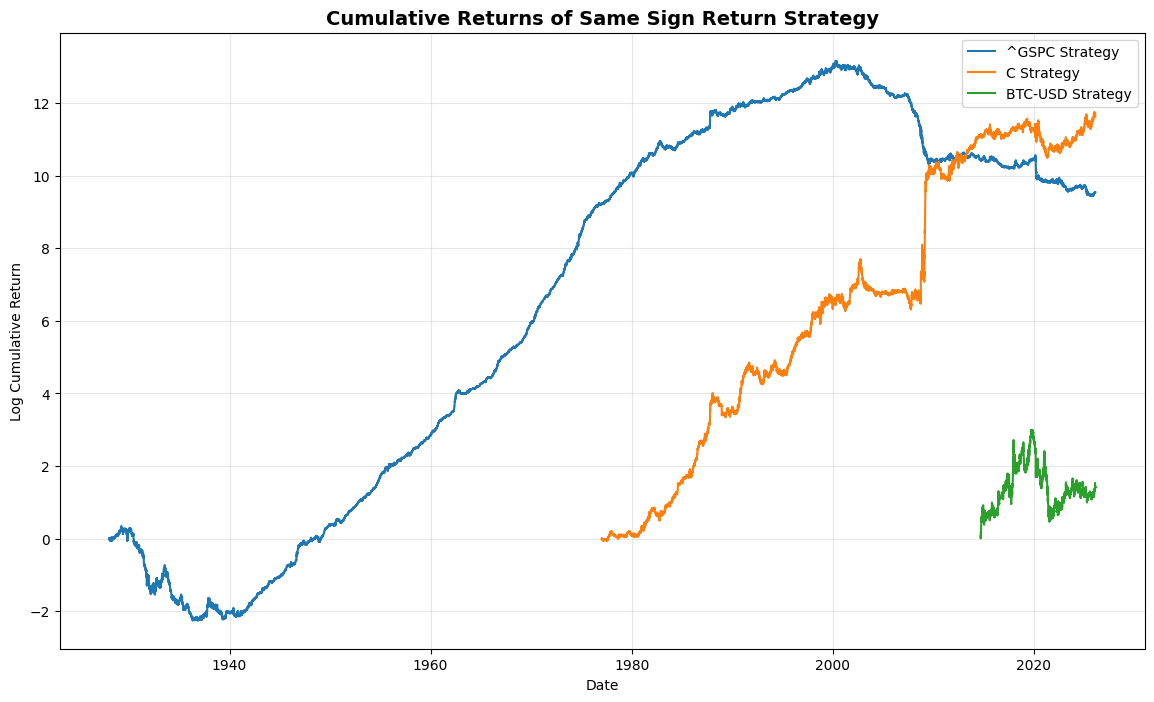

In [19]:
# 1. Same sign return strategy
# Select three different tickers
tickers_strat = ["^GSPC", "C", "BTC-USD"]

plt.figure(figsize=(14, 8))

for ticker in tickers_strat:
    prices = daily_df[ticker].dropna()
    log_rets = np.log(prices).diff()
    
    position = np.sign(log_rets.shift(1))
    strat_rets = position * log_rets
    strat_cum = strat_rets.cumsum()

    plt.plot(strat_cum.index, strat_cum.values, label=f"{ticker} Strategy")

plt.title("Cumulative Returns of Same Sign Return Strategy", fontsize=14, fontweight='bold')
plt.xlabel("Date")
plt.ylabel("Log Cumulative Return")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Nous avons sélectionné les titres ^GSPC, C et BTC-USD pour appliquer la stratégie qui consiste à prendre une position du même signe que celui du rendement précédent.

Dans le cas du S&P 500 (^GSPC), on distingue deux régimes : de 1930 aux années 2000, la stratégie de suivre le signe du rendement précédent génère des rendements positifs de performance exponentielle, ce qui suggère une certaine prévisibilité dans les rendements. Il y a une forte autocorrélation positive des rendements, ce qui signifie que les rendements positifs sont suivis de rendements positifs et les rendements négatifs sont suivis de rendements négatifs. Le marché ne serait donc pas totalement efficient, et il serait possible de tirer profit de cette prévisibilité.

Cependant, à partir des années 2000, on observe une forte diminution de la performance de la stratégie, avec une courbe qui commence à décliner. Cela suggère une diminution de l'autocorrélation positive des rendements, et donc une diminution de la prévisibilité. Le marché serait devenu plus efficient, rendant cette stratégie moins rentable, voire perdante à cause de l'arrivée du trading algorithmique, de l'informatisation des bourses et de la baisse des coûts de transaction, qui ont permis une exploitation plus rapide et plus efficace de ces opportunités de prévisibilité, réduisant ainsi leur durée de vie.

Dans le cas de la banque Citigroup (C), on observe une performance positive sur le long terme. Contrairement à l'indice S&P 500, la stratégie de suivre le signe du rendement précédent semble générer des rendements positifs de manière plus stable et continue, même après les années 2000 et en particulier après la crise financière de 2008. Cela suggère que les rendements de Citigroup présentent une autocorrélation positive plus persistante que ceux du S&P 500, ce qui pourrait être dû à des facteurs spécifiques à l'entreprise ou au secteur bancaire, tels que des cycles économiques plus marqués ou une plus grande sensibilité aux événements macroéconomiques.

Pour le Bitcoin (BTC-USD), on observe que la stratégie peine à générer des rendements positifs de manière stable. Cela suggère que le marché crypto est très bruité et présente une faible autocorrélation des rendements, ce qui rend la stratégie de suivre le signe du rendement précédent moins efficace. La forte volatilité et la nature spéculative du marché crypto peuvent contribuer à cette absence de prévisibilité, rendant les rendements plus erratiques et moins susceptibles de suivre des tendances persistantes.

,long_mean,short_mean,t_stat,p_val
^GSPC,0.000593,0.000166,2.750884,0.005948
C,0.001268,0.000729,1.146951,0.251426
BTC-USD,0.001473,-0.000917,2.173030,0.029835


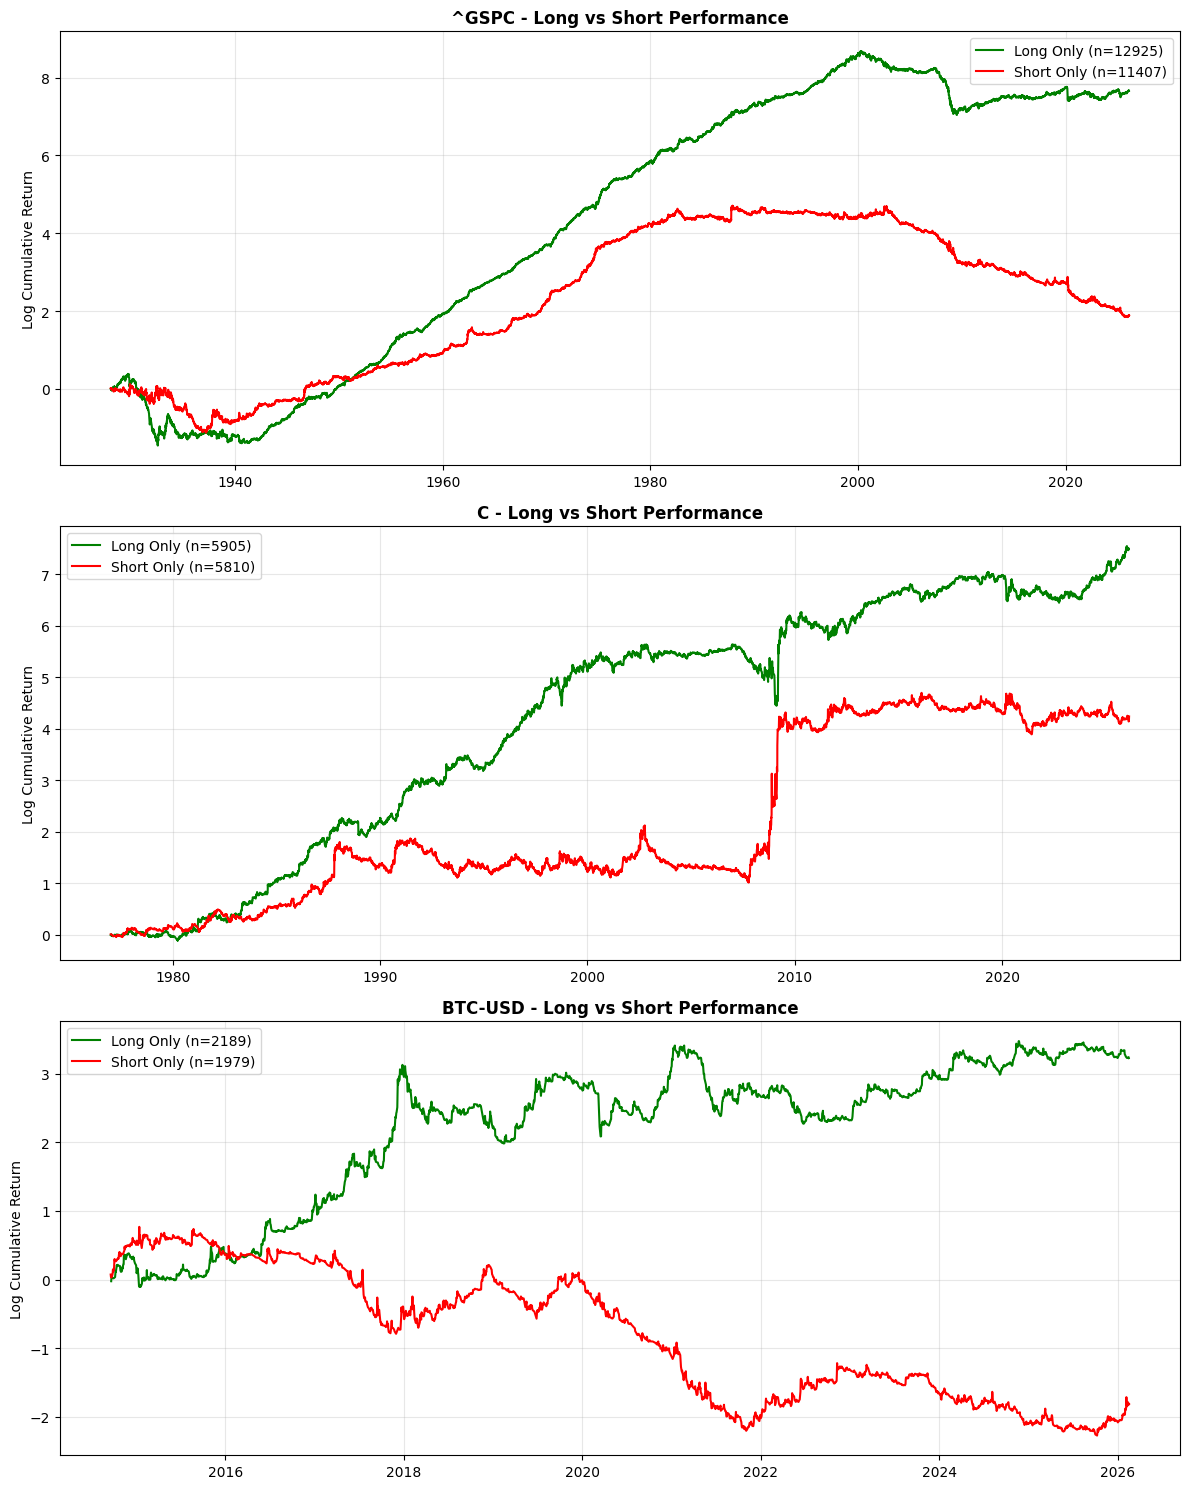

In [20]:
# 2. Short and long positions
fig, axes = plt.subplots(len(tickers_strat), 1, figsize=(12, 5 * len(tickers_strat)))

strategy_results = {}

for i, ticker in enumerate(tickers_strat):
    prices = daily_df[ticker].dropna()
    log_rets = np.log(prices).diff().dropna()
    signal = np.sign(log_rets.shift(1)).dropna()
    aligned_rets = log_rets.loc[signal.index]
    
    rets_long = aligned_rets[signal == 1]
    rets_short = -1 * aligned_rets[signal == -1]
    
    # Perform t-test
    t_stat, p_val = stats.ttest_ind(rets_long, rets_short, equal_var=False)
    
    strategy_results[ticker] = {
        'long_mean': rets_long.mean(),
        'short_mean': rets_short.mean(),
        't_stat': t_stat,
        'p_val': p_val
    }
    
    ax = axes[i]
    
    cum_long = rets_long.cumsum()
    cum_short = rets_short.cumsum()
    ax.plot(cum_long.index, cum_long.values, label=f'Long Only (n={len(rets_long)})', color='green')
    ax.plot(cum_short.index, cum_short.values, label=f'Short Only (n={len(rets_short)})', color='red')
    
    ax.set_title(f"{ticker} - Long vs Short Performance", fontweight='bold')
    ax.set_ylabel("Log Cumulative Return")
    ax.legend()
    ax.grid(alpha=0.3)

display(pd.DataFrame(strategy_results).T)

plt.tight_layout()
plt.show()

En utilisant un test de Student pour comparer la performance long et short, on trouve que la différence est statistiquement significative pour le titre ^GSPC (S&P 500) avec une $p-value \approx 0.006 < 0.05$. La moyenne des rendements long est significativement supérieure à celle des rendements short ($\approx 5.9 \times 10^{-4}$ contre $\approx 1.6 \times 10^{-4}$).
On voit que la composante short a cessé de fonctionner à partir des années 2000, tandis que la composante long continue de générer des rendements positifs, ce qui suggère que la prévisibilité a disparu pour la composante short, mais pas pour la composante long.

Pour le Bitcoin (BTC-USD), la différence entre les rendements long et short est également significative avec une $p-value \approx 0.03 < 0.05$. C'est un cas où la stratégie long gagne de l'argent en moyenne, tandis que la stratégie short en perd (moyenne négative). La courbe de performance cumulée de la stratégie short s'effondre, ce qui suggère que la stratégie short est particulièrement pénalisante dans le cas du Bitcoin. Pour un actif à très fort drift haussier, la composante short doit lutter contre ce drift, ce qui rend la stratégie short plus difficile à rentabiliser.

Pour le titre C (Citigroup), la différence entre les rendements long et short n'est pas statistiquement significative, avec une $p-value \approx 0.25$. Bien que la performance cumulée de la stratégie long soit supérieure à celle de la stratégie short, cette différence n'est pas suffisamment grande pour être considérée comme significative d'un point de vue statistique.
Le graphique montre un saut massif de la stratégie short en 2008. C'est une exception où pendant la crise financière, la stratégie short a généré des rendements positifs. C'est probablement ce gain énorme qui a permis à la stratégie short de ne pas être significativement perdante sur l'ensemble de la période lors de notre test de Student, malgré une performance cumulée globalement inférieure à celle de la stratégie long.

Ainsi on observe d'abord un phénomène de drift, où la composante long bénéficie d'une tendance naturelle du marché à monter sur le long terme. La composante short doit donc lutter contre le courant. Le signal de baisse doit être suffisamment fort pour compenser ce drift, ce qui rend la stratégie short plus difficile à rentabiliser.

Enfin, la performance est significativement différente pour l'indice et la cryptomonnaire, confirmant l'existance d'un biais haussier structurel. Etre long est avantagé par l'économie, tandis que être short sur la base d'un signal aussi simple que le signe du rendement précédent ne suffit plus à générer des rendements positifs, en particulier pour les actifs à fort drift haussier comme le Bitcoin.